# EuRoc Evaluation wrt GT

In [6]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 

import pandas as pd
import os
import pprint

from evo.core.trajectory import PoseTrajectory3D
from evo.tools import plot
from evo.core import metrics
from evo.core import sync

from pose_trajectory_evaluation import PoseTrajectoryEvaluation

%reload_ext autoreload
%autoreload 2

In [2]:
dataset_path = '/media/berlukas/Data/data/datasets/EuRoc/'
export_paths = ['MH_01', 'MH_02', 'MH_03', 'MH_05']
exported_missions = ['c3d7929a77bba0160c00000000000000', '8fc4b6d277bba0160c00000000000000', 'c5043f496abba0160c00000000000000', '']
eval = PoseTrajectoryEvaluation()

est_trajectories = []
gt_trajectories = []
onboard_trajectories = []

assert len(export_paths) == len(exported_missions)
idx = 0
for export_path, mission_id in zip(export_paths, exported_missions):
    print(f'Loading dataset[{idx}]: {export_path}')
    est_traj_filename = dataset_path + 'MH_est.csv'
    gt_traj_filename = dataset_path + export_path + '_gt.csv'
    onboard_traj_filename = dataset_path + export_path + '_rovio.npy'

    est_df = eval.get_mission_from_csv(est_traj_filename, mission_id)
    est_trajectories.append(eval.convert_df_to_traj(est_df))
    
    gt_df = eval.parse_trajectory_txt(gt_traj_filename, delimiter = ',')
    gt_trajectories.append(eval.convert_df_to_traj(gt_df))
    
    onboard_trajectories.append(np.load(onboard_traj_filename))    
    idx = idx + 1
    
assert len(gt_trajectories) == len(est_trajectories)
assert len(gt_trajectories) == len(onboard_trajectories)
print(f'Loaded {len(gt_trajectories)} missions.')

onboard_trajectories[1] = onboard_trajectories[1][0:len(onboard_trajectories[1])-130,:]
onboard_trajectories[3] = onboard_trajectories[3][0:len(onboard_trajectories[3])-50,:]

Loading dataset[0]: MH_01
Loading dataset[1]: MH_02
Loading dataset[2]: MH_03
Loading dataset[3]: MH_05
Loaded 4 missions.


------------------------------------------------------

In [3]:
max_diff = 10

delta = 10
delta_unit = metrics.Unit.frames
all_pairs = False

In [4]:
def plot_evaluations_APE(data, ape_metric, ape_stats):
    # Trajectory plot
    fig = plt.figure(figsize=(8, 6), dpi=160)
    traj_by_label = {
        "estimate": data[1],
        "reference": data[0]
    }
    plot.trajectories(fig, traj_by_label, plot.PlotMode.xy)
    plt.show()

    # Trajectory plot
    seconds_from_start = [t - data[1].timestamps[0] for t in data[1].timestamps]
    fig = plt.figure(figsize=(8, 6), dpi=160)
    plot.error_array(fig.gca(), ape_metric.error, x_array=seconds_from_start,
                     statistics={s:v for s,v in ape_stats.items() if s != "sse"},
                     name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
    plt.show()

    plot_mode = plot.PlotMode.xy
    fig = plt.figure(figsize=(8, 6), dpi=160)
    ax = plot.prepare_axis(fig, plot_mode)
    plot.traj(ax, plot_mode, gt_traj, '--', "gray", "reference")
    plot.traj_colormap(ax, data[1], ape_metric.error, 
                       plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
    ax.legend()
    plt.show()

def perform_evaluation_using_data(data, delta, delta_unit, all_pairs):
    print('--- Translational Part -----------------------------')
    pose_relation = metrics.PoseRelation.translation_part
    print('APE:')
    ape_metric_trans = metrics.APE(pose_relation)
    ape_metric_trans.process_data(data)
    ape_stat_trans = ape_metric_trans.get_statistic(metrics.StatisticsType.rmse)
    ape_stats_trans = ape_metric_trans.get_all_statistics()
    pprint.pprint(ape_stats_trans)

#     print('RPE:')
#     rpe_metric_trans = metrics.RPE(pose_relation, delta, delta_unit, all_pairs)
#     rpe_metric_trans.process_data(data)
#     rpe_stat_trans = rpe_metric_trans.get_statistic(metrics.StatisticsType.rmse)
#     rpe_stats_trans = rpe_metric_trans.get_all_statistics()
#     pprint.pprint(rpe_stats_trans)
#     print('\n\n')

    print('--- Rotational Part -----------------------------')
    pose_relation = metrics.PoseRelation.rotation_angle_deg
    print('APE:')
    ape_metric_rot = metrics.APE(pose_relation)
    ape_metric_rot.process_data(data)
    ape_stat_rot = ape_metric_rot.get_statistic(metrics.StatisticsType.rmse)
    ape_stats_rot = ape_metric_rot.get_all_statistics()
    pprint.pprint(ape_stats_rot)

#     print('RPE:')
#     rpe_metric_rot = metrics.RPE(pose_relation, delta, delta_unit, all_pairs)
#     rpe_metric_rot.process_data(data)
#     rpe_stat_rot = rpe_metric_rot.get_statistic(metrics.StatisticsType.rmse)
#     rpe_stats_rot = rpe_metric_rot.get_all_statistics()
#     pprint.pprint(rpe_stats_rot)

    plot_evaluations_APE(data, ape_metric_trans, ape_stats_trans)

=== Onboard ===========================================================
--- Translational Part -----------------------------
APE:
{'max': 0.5438070374971102,
 'mean': 0.2734409862889956,
 'median': 0.31423117506873627,
 'min': 0.012316269172691399,
 'rmse': 0.29600946810966644,
 'sse': 254.54076313669898,
 'std': 0.1133650397074378}
--- Rotational Part -----------------------------
APE:
{'max': 179.97488764323424,
 'mean': 170.10151152617007,
 'median': 170.02444858993263,
 'min': 150.18465738195027,
 'rmse': 170.2370388094619,
 'sse': 84188786.45649436,
 'std': 6.79155056864502}


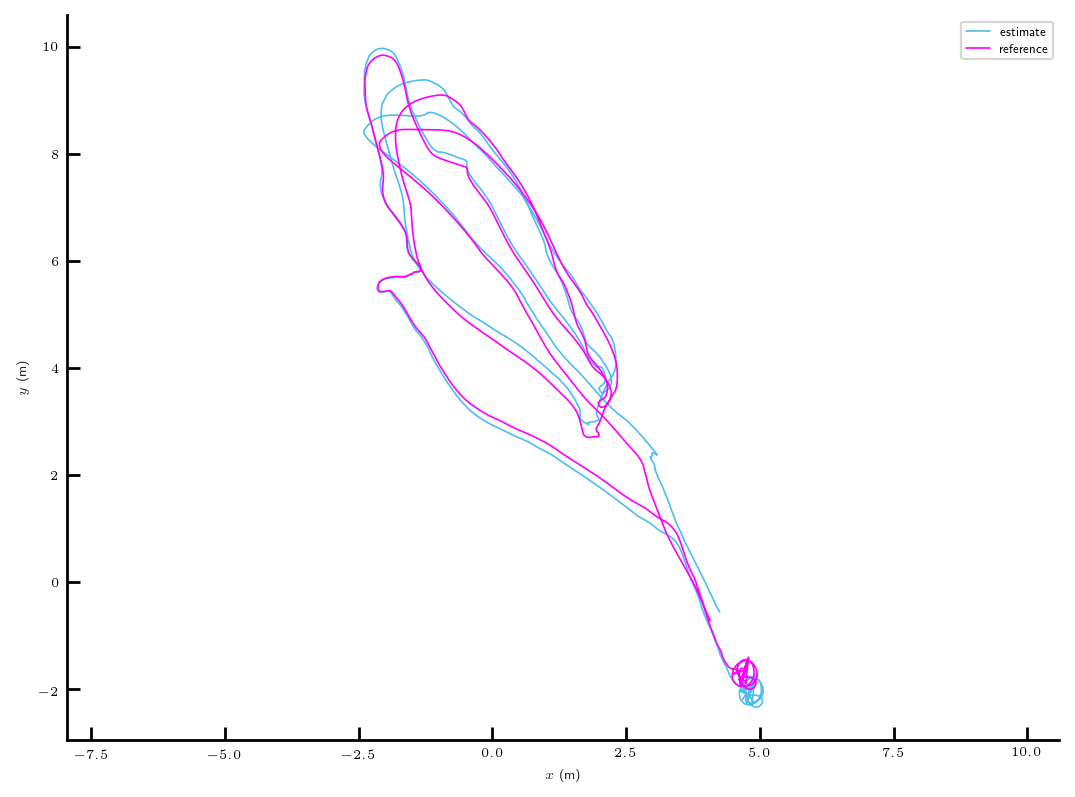

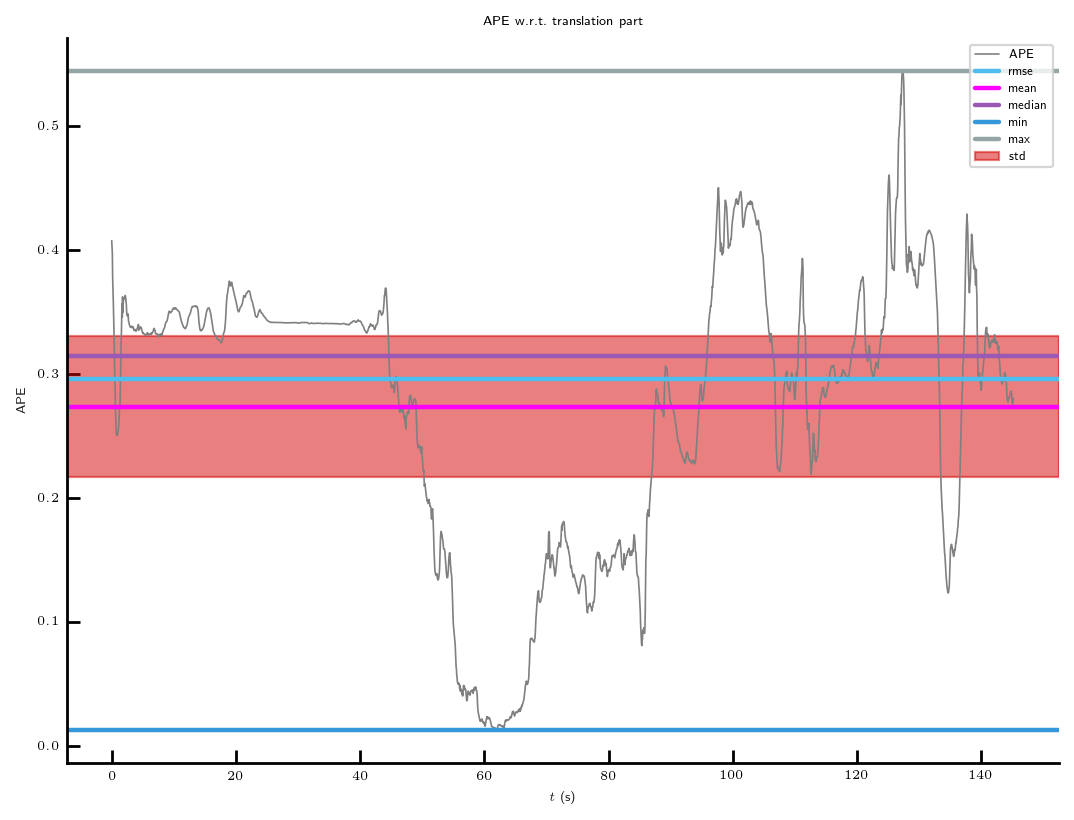

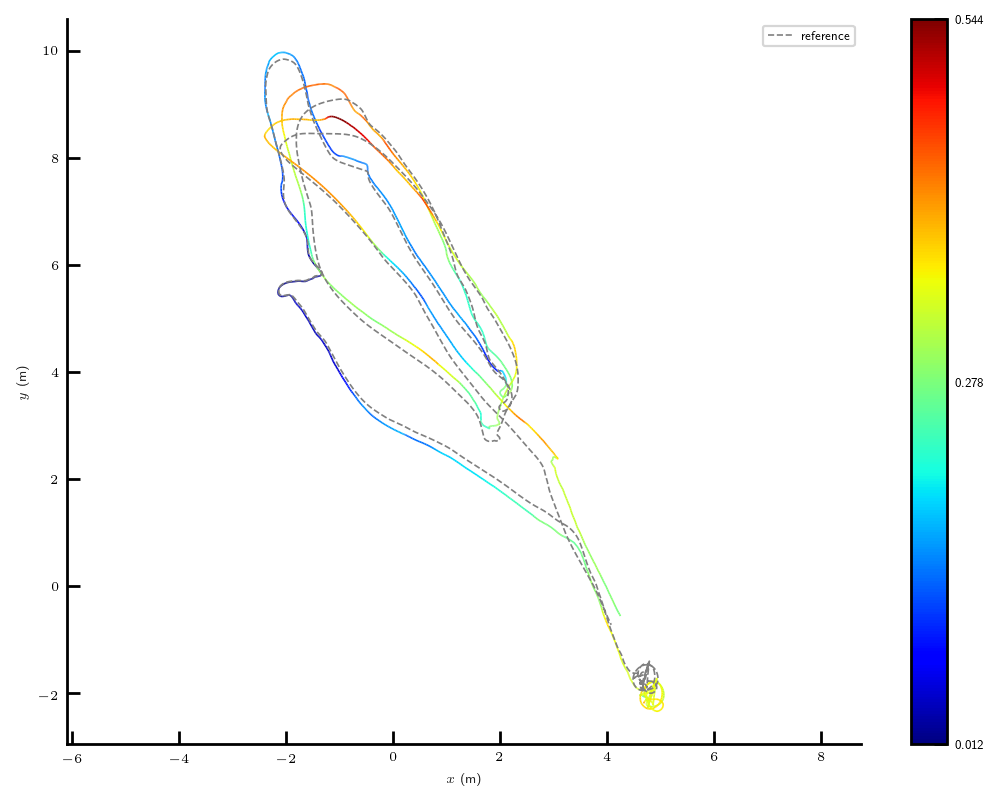

In [8]:
def ts_ns_to_seconds(ts_ns):
    k_ns_per_s = 1e9;
    return ts_ns / k_ns_per_s;

def convert_est_to_traj(trajectory):
    ts = ts_ns_to_seconds(trajectory[:,0])
    xyz = trajectory[:,1:4]
    wxyz = trajectory[:,4:8]
    return PoseTrajectory3D(positions_xyz = xyz, orientations_quat_wxyz = wxyz, timestamps = ts)

def convert_gt_to_traj(trajectory):
    ts = trajectory[:,0]
    xyz = trajectory[:,1:4]
    wxyz = trajectory[:,4:8]
    return PoseTrajectory3D(positions_xyz = xyz, orientations_quat_wxyz = wxyz, timestamps = ts)

def convert_onboard_to_traj(trajectory):
    ts = ts_ns_to_seconds(trajectory[:,0])
    xyz = trajectory[:,1:4]
#     xyz = np.zeros((trajectory.shape[0],3))
#     xyz[:,0:2] = trajectory[:,1:3]
    wxyz = trajectory[:,4:8]
    return PoseTrajectory3D(positions_xyz = xyz, orientations_quat_wxyz = wxyz, timestamps = ts)

idx = 1

print(f'=== Onboard ===========================================================')
onb_traj = convert_onboard_to_traj(onboard_trajectories[idx])
gt_traj = convert_est_to_traj(gt_trajectories[idx])
gt_traj, onb_traj = sync.associate_trajectories(gt_traj, onb_traj, max_diff)
onb_traj.align(gt_traj, correct_scale=False, correct_only_scale=False)
data = (gt_traj, onb_traj)
perform_evaluation_using_data(data, delta, delta_unit, all_pairs)

# print(f'=== Maplab ===========================================================')
# est_traj = convert_est_to_traj(est_trajectories[idx])
# gt_traj = convert_est_to_traj(gt_trajectories[idx])
# gt_traj, est_traj = sync.associate_trajectories(gt_traj, est_traj, max_diff)
# est_traj.align(gt_traj, correct_scale=False, correct_only_scale=False)
# data = (gt_traj, est_traj)
# perform_evaluation_using_data(data, delta, delta_unit, all_pairs)

In [35]:
print(gt_traj)
print(onb_traj)

2905 poses, 71.818m path length, 144.315s duration
2905 poses, 72.876m path length, 145.200s duration


In [15]:
g = sns.catplot(
    data=penguins, kind="bar",
    x="species", y="body_mass_g", hue="sex",
    ci="sd", palette="dark", alpha=.6, height=6
)

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:941: MatplotlibDeprecationWarning: nbagg.transparent is deprecated and ignored. Use figure.facecolor instead.
  mplDeprecation)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

RuntimeError: latex was not able to process the following string:
b'body_mass_g'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/berlukas/.cache/matplotlib/tex.cache/db5b180fbc4b9e056615f2cc9340cd09.te
x
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 84 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file db5b180fbc4b9e056615f2cc9340cd09.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.13 ...size{12.000000}{15.000000}{\sffamily body_
                                                  mass_g}
No pages of output.
Transcript written on db5b180fbc4b9e056615f2cc9340cd09.log.




In [12]:
import pandas as pd

us_mh1 = 0.118736383442
us_mh2 = 0.125906394199
us_mh3 = 0.167037861915

# initialize list of lists
data = [['MH1', 'cvi', 0.119, 0.697], ['MH2', 'cvi', 0.135, 0.707], ['MH3', 'cvi', 0.151, 0.720], ['MH1', 'ours', 0.119, 42], ['MH2', 'ours', 0.126, 42], ['MH3', 'ours', 0.167, 42]]



# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['sequence', 'method', 'agent_to_server', 'server_to_agent'])
df
 

,sequence,method,agent_to_server,server_to_agent
0,MH1,cvi,0.119,0.697
1,MH2,cvi,0.135,0.707
2,MH3,cvi,0.151,0.720
3,MH1,ours,0.119,42.000
4,MH2,ours,0.126,42.000
5,MH3,ours,0.167,42.000


In [14]:
g = sns.catplot(
    data=df, kind="bar",
    x="sequence", y="agent_to_server", hue="method",
    ci="sd", palette="dark", alpha=.6, height=6
)

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:941: MatplotlibDeprecationWarning: nbagg.transparent is deprecated and ignored. Use figure.facecolor instead.
  mplDeprecation)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

RuntimeError: latex was not able to process the following string:
b'agent_to_server'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/berlukas/.cache/matplotlib/tex.cache/e550c1f4eec2bcf2a590f4bb247c136c.te
x
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 84 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./e550c1f4eec2bcf2a590f4bb247c136c.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.13 ...ize{12.000000}{15.000000}{\sffamily agent_
                                                  to_server}
No pages of output.
Transcript written on e550c1f4eec2bcf2a590f4bb247c136c.log.


